# Распознавание объектов на изображениях из набора данных CIFAR-10

Учебный курс "[Программирование глубоких нейронных сетей на Python](https://openedu.ru/course/urfu/PYDNN/)".

In [1]:
"""Импортируем вспомогательные библиотеки"""
import numpy as np
import pandas as pd
#import tensorflow
"""Импортируем все для работы с предварительно обученной сетью VGG16"""
#from tensorflow.keras.applications.vgg16 import VGG16
#from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.applications import ResNet50, InceptionV3, DenseNet201, Xception
"""Импортируем слои нейронной сети и вспомогательные инструменты"""
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow import image
from tensorflow.keras import utils
import matplotlib.pyplot as plt
%matplotlib inline 

"""Зафиксируем генератор случайных чисел. Его не менять!!!"""
from numpy.random import seed
seed(2020)
from tensorflow.random import set_seed
set_seed(2020)

import os
""" посмотрим, какие файлы храняться в директории """
for dirname, _, filenames in os.walk('/kaggle/input/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/cnn-urfu-cifar10/train.npy
/kaggle/input/cnn-urfu-cifar10/train_label.npy
/kaggle/input/cnn-urfu-cifar10/sample_submission.csv
/kaggle/input/cnn-urfu-cifar10/test.npy


In [2]:
# Названия классов из набора данных CIFAR-10
classes=['самолет', 'автомобиль', 'птица', 'кот', 'олень', 'собака', 'лягушка', 'лошадь', 'корабль', 'грузовик']

## Подготовка данных

In [3]:
"""Так как данные храняться не в формате таблиц, а в формате многомерных тензоров numpy,
то применим для загрузки данных функцию numpy load()"""
X_train = np.load('/kaggle/input/cnn-urfu-cifar10/train.npy')
Y_train = np.load('/kaggle/input/cnn-urfu-cifar10/train_label.npy')
X_test = np.load('/kaggle/input/cnn-urfu-cifar10/test.npy')
X_train.shape, Y_train.shape, X_test.shape

((56000, 32, 32, 3), (56000, 1), (4000, 32, 32, 3))

Нормализуем данные

In [4]:
"""Преобразуем размер изображений. Не все предварительно обученные сети могут принимать на вход
такие маленькие изображения, как 32х32.
Если для какой-то модели вам понадобиться больший размер, то просто поменяйте цифры"""
X_train = image.resize(X_train, [64,64])
X_test = image.resize(X_test, [64,64])
#x_train = preprocess_input(X_train)
#x_test = preprocess_input(X_test)


layer = Normalization()
layer.adapt(X_train)
x_train = layer(X_train)

layer = Normalization()
layer.adapt(X_test)
x_test = layer(X_test)

**Преобразуем правильные ответы в формат one hot encoding**

In [5]:
y_train = utils.to_categorical(Y_train, 10)

## Создаем нейронную сеть

In [6]:
# загружам предварительно обученную нейронную сеть
#vgg16_net = ResNet50(weights='imagenet', 
#                  include_top=False, 
#                  input_shape=(64, 64, 3))
#vgg16_net.trainable = False

vgg16_net = DenseNet201(weights='imagenet', 
                  include_top=False, 
                  input_shape=(64, 64, 3))
vgg16_net.trainable = False



74842112/74836368 [==============================] - 2s 0us/step


In [7]:
vgg16_net.summary()

Model: "densenet201"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 32, 32, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1/conv[0][0]                 
________________________________________________________________________________________

Total params: 18,321,984
Trainable params: 0
Non-trainable params: 18,321,984
__________________________________________________________________________________________________


In [8]:
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomContrast

seed(2020)
set_seed(2020)

data_augmentation = Sequential()
data_augmentation.add(RandomFlip("horizontal"))
data_augmentation.add(RandomContrast([0.7,1.2]))

model = Sequential()
# Добавляем модель VGG16 в сеть как слой
# model.add(data_augmentation)
model.add(vgg16_net)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(10, activation='softmax'))

**Компилируем модель**

In [9]:
model.compile(loss='categorical_crossentropy',
              optimizer="nadam",
              metrics=['accuracy'])

# Обучаем нейронную сеть

In [12]:
history = model.fit(x_train, y_train,
              batch_size=128,
              epochs=3,
              validation_split=0.21, #0.08
              verbose=1)

Epoch 1/3
346/346 [==============================] - 26s 76ms/step - loss: 0.5471 - accuracy: 0.8154 - val_loss: 0.5647 - val_accuracy: 0.8076
Epoch 2/3
346/346 [==============================] - 25s 73ms/step - loss: 0.5026 - accuracy: 0.8271 - val_loss: 0.5136 - val_accuracy: 0.8275
Epoch 3/3
346/346 [==============================] - 25s 73ms/step - loss: 0.4712 - accuracy: 0.8396 - val_loss: 0.5049 - val_accuracy: 0.8276


## Оцениваем качество обучения сети

In [13]:
# Оцениваем качество обучения модели на тестовых данных
scores = model.evaluate(x_test, verbose=1)
print(scores)
print("Доля верных ответов на тестовых данных, в процентах:", round(scores[1] * 100, 4))


125/125 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
[0.0, 0.0]
Доля верных ответов на тестовых данных, в процентах: 0.0


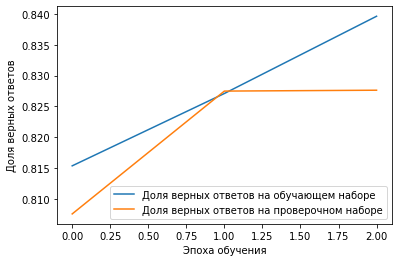

In [14]:
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

# Тонкая настройка нейронной сети

In [15]:
vgg16_net.trainable = True
#trainable = False
trainable = True
for layer in vgg16_net.layers:
    #if (layer.name == 'block5_conv1'):
    #    trainable = True
    layer.trainable = trainable

In [16]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=1e-5), 
              metrics=['accuracy'])

In [17]:
history = model.fit(x_train, y_train,
              batch_size=64,
              epochs=5,
              validation_split=0.1,
              verbose=1)

Epoch 1/5
788/788 [==============================] - 34s 44ms/step - loss: 0.4273 - accuracy: 0.8531 - val_loss: 0.5498 - val_accuracy: 0.8193
Epoch 2/5
788/788 [==============================] - 31s 39ms/step - loss: 0.4067 - accuracy: 0.8625 - val_loss: 0.5504 - val_accuracy: 0.8204
Epoch 3/5
788/788 [==============================] - 31s 40ms/step - loss: 0.4007 - accuracy: 0.8629 - val_loss: 0.5513 - val_accuracy: 0.8213
Epoch 4/5
788/788 [==============================] - 31s 39ms/step - loss: 0.3915 - accuracy: 0.8671 - val_loss: 0.5514 - val_accuracy: 0.8218
Epoch 5/5
788/788 [==============================] - 31s 40ms/step - loss: 0.3888 - accuracy: 0.8666 - val_loss: 0.5508 - val_accuracy: 0.8236


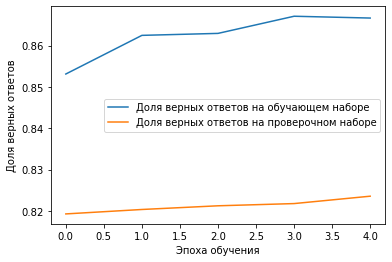

In [18]:
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

## Готовим данные для теста на liderboard

**Распознаем тестовый набор данных**

In [ ]:
"""делаем предсказания по всем тестовым данным"""
predictions = model.predict(x_test)
"""извлекаем номера предсказаний с максимальными вероятностями по всем объектам тестового набора"""
predictions = np.argmax(predictions, axis=1)
predictions

**Пишем результаты предсказаний в шаблон "sample_submission"**

In [ ]:
"""используем файл с правильным шаблоном формата записи ответов и пишем в него наши предсказания"""
sample_submission = pd.read_csv('/kaggle/input/cnn-urfu-cifar10/sample_submission.csv')
sample_submission['label'] = predictions

**Записываем ответы для проверки на liderboard**

In [ ]:
"""to_csv - пишет табличные данные в файл '.csv' """
sample_submission.to_csv('sample_submission.csv', index=False)